# import appropriate libraries

In [1]:
import os
from shutil import copy2
import csv
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import tensorflow_hub as hub
import seaborn as sns
import requests

In [2]:
tf.__version__

'2.18.0'

In [3]:
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

                                         image_paths  filename image_category
0     C:\Users\KIIT\Desktop\dataset\Aloevera\339.jpg   339.jpg       Aloevera
105  C:\Users\KIIT\Desktop\dataset\Aloevera\4322.jpg  4322.jpg       Aloevera
106  C:\Users\KIIT\Desktop\dataset\Aloevera\4323.jpg  4323.jpg       Aloevera
107  C:\Users\KIIT\Desktop\dataset\Aloevera\4324.jpg  4324.jpg       Aloevera
108  C:\Users\KIIT\Desktop\dataset\Aloevera\4325.jpg  4325.jpg       Aloevera


<Axes: xlabel='image_category', ylabel='count'>

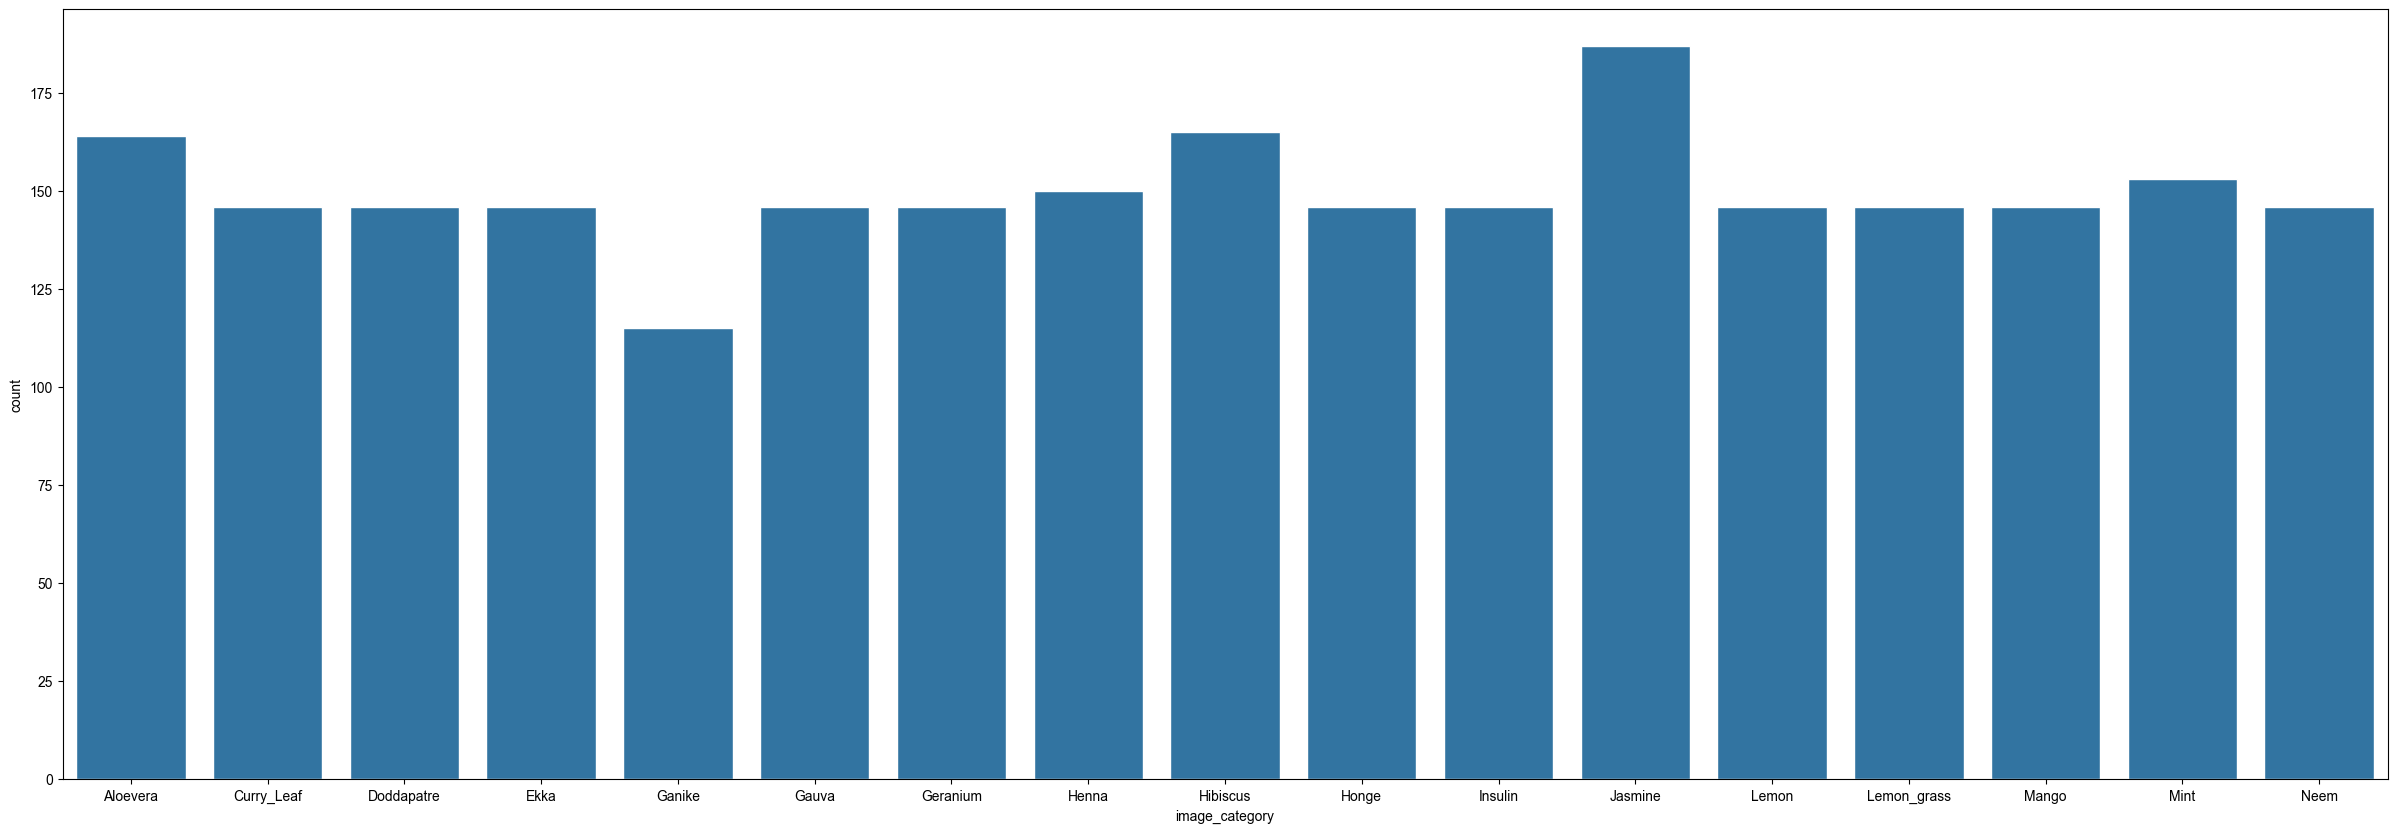

In [4]:
data_root = (r"C:\Users\KIIT\Desktop\dataset")
# Set path to the data set
dataset_path = r'C:\Users\KIIT\Desktop\dataset'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]
dataset_df = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
dataset_df.sort_values('image_category',inplace=True)
print(dataset_df.head())
fig, ax = plt.subplots(figsize=(30, 10))
sns.set(style="darkgrid")
sns.countplot(x="image_category", data=dataset_df, ax = ax)

# Rescale images and split data into training and validation sets

In [5]:
IMAGE_SHAPE = (224, 224)                                         
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

# visualize the data
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

Found 504 images belonging to 17 classes.
Found 2036 images belonging to 17 classes.


((32, 224, 224, 3), (32, 17))

# The image labels are mapped onto indices and the labels written to a text file

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'Aloevera': 0, 'Curry_Leaf': 1, 'Doddapatre': 2, 'Ekka': 3, 'Ganike': 4, 'Gauva': 5, 'Geranium': 6, 'Henna': 7, 'Hibiscus': 8, 'Honge': 9, 'Insulin': 10, 'Jasmine': 11, 'Lemon': 12, 'Lemon_grass': 13, 'Mango': 14, 'Mint': 15, 'Neem': 16}


In [7]:
!type labels.txt

Aloevera
Curry_Leaf
Doddapatre
Ekka
Ganike
Gauva
Geranium
Henna
Hibiscus
Honge
Insulin
Jasmine
Lemon
Lemon_grass
Mango
Mint
Neem


# Load a pretrained model from tensorflow hub

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

class HubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url):
        super(HubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Now use the custom HubLayer in the Sequential model
model = tf.keras.Sequential([
    HubLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer (HubLayer)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 17)             │        21,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,777 (85.07 KB)

 Trainable params: 21,777 (85.07 KB)

 Non-trainable params: 0 (0.00 B)

# Choose an Optimizer and compile the model

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

# Set number of epocs and other parameters and fit the model

## Training the model

In [12]:
steps_per_epoch = int(np.ceil(train_generator.samples/train_generator.batch_size))
val_steps_per_epoch = int(np.ceil(valid_generator.samples/valid_generator.batch_size))

hist = model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - acc: 0.3769 - loss: 2.1274 - val_acc: 0.8115 - val_loss: 0.7920
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 673ms/step - acc: 0.7636 - loss: 0.8218 - val_acc: 0.8810 - val_loss: 0.5051
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 556ms/step - acc: 0.8528 - loss: 0.5194 - val_acc: 0.8988 - val_loss: 0.4046
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 531ms/step - acc: 0.8774 - loss: 0.4031 - val_acc: 0.9167 - val_loss: 0.3410
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 530ms/step - acc: 0.9009 - loss: 0.3431 - val_acc: 0.9206 - val_loss: 0.2950
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - acc: 0.9318 - loss: 0.2571 - val_acc: 0.9246 - val_loss: 0.2565
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - acc

# Plots of training and validation accuracy

Validation batch shape: (32, 224, 224, 3)
['Aloevera' 'Curry_Leaf' 'Doddapatre' 'Ekka' 'Ganike' 'Gauva' 'Geranium'
 'Henna' 'Hibiscus' 'Honge' 'Insulin' 'Jasmine' 'Lemon' 'Lemon_Grass'
 'Mango' 'Mint' 'Neem']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Prediction results shape: (32, 17)
['Neem' 'Ekka' 'Ekka' 'Ganike' 'Insulin' 'Ekka' 'Aloevera' 'Mango' 'Gauva'
 'Jasmine' 'Doddapatre' 'Neem' 'Honge' 'Mango' 'Ekka' 'Insulin' 'Jasmine'
 'Curry_Leaf' 'Mint' 'Ekka' 'Lemon' 'Henna' 'Hibiscus' 'Hibiscus' 'Neem'
 'Doddapatre' 'Aloevera' 'Geranium' 'Lemon_Grass' 'Curry_Leaf' 'Insulin'
 'Geranium']


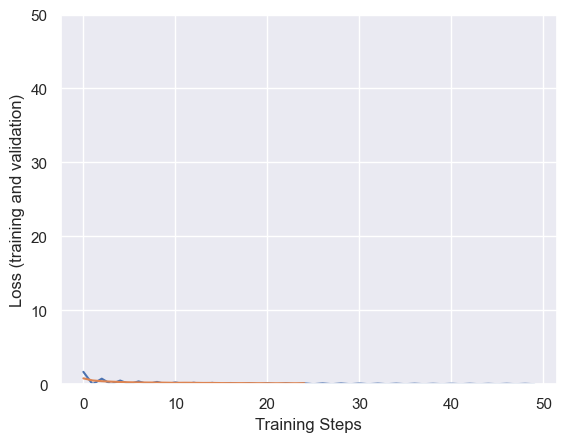

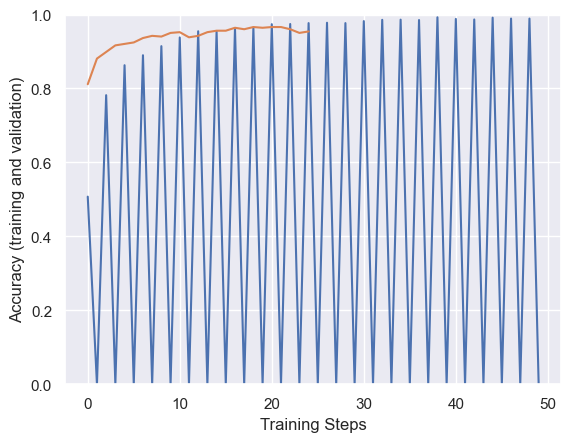

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

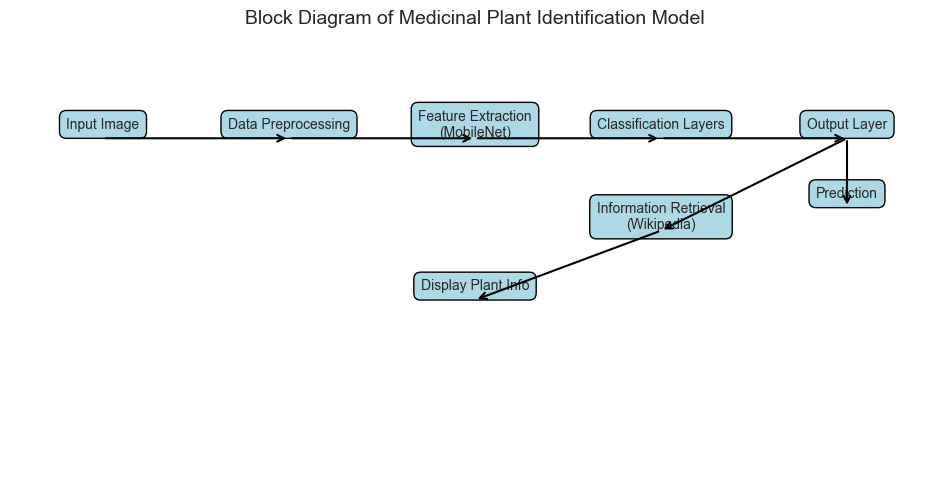

In [23]:
import matplotlib.pyplot as plt

# Define figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

# Define box style with improved padding
box_style = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightblue")

# Define positions of blocks with better vertical spacing to reduce overlap
positions = {
    "Input Image": (0.1, 0.8),
    "Data Preprocessing": (0.3, 0.8),
    "Feature Extraction\n(MobileNet)": (0.5, 0.8),
    "Classification Layers": (0.7, 0.8),
    "Output Layer": (0.9, 0.8),
    "Prediction": (0.9, 0.65),
    "Information Retrieval\n(Wikipedia)": (0.7, 0.6),
    "Display Plant Info": (0.5, 0.45)
}

# Draw blocks with better spacing and alignment
for text, pos in positions.items():
    ax.text(pos[0], pos[1], text, ha="center", va="center", fontsize=10, bbox=box_style)

# Draw arrows with adjusted positioning to avoid overlap with text
arrows = [
    ("Input Image", "Data Preprocessing"),
    ("Data Preprocessing", "Feature Extraction\n(MobileNet)"),
    ("Feature Extraction\n(MobileNet)", "Classification Layers"),
    ("Classification Layers", "Output Layer"),
    ("Output Layer", "Prediction"),
    ("Output Layer", "Information Retrieval\n(Wikipedia)"),
    ("Information Retrieval\n(Wikipedia)", "Display Plant Info")
]

# Adjust arrow positions slightly to improve clarity and set color to black
for start, end in arrows:
    # Adjust the arrow head and tail placement to avoid overlap
    ax.annotate(
        "", 
        xy=(positions[end][0], positions[end][1] - 0.03), 
        xytext=(positions[start][0], positions[start][1] - 0.03), 
        arrowprops=dict(arrowstyle="->", color="black", lw=1.5)
    )

# Add title
plt.title("Block Diagram of Medicinal Plant Identification Model", fontsize=14)

# Show plot
plt.show()





# Make predictions and compare output with ground truth 
# Green for correct and red for wrong predictions

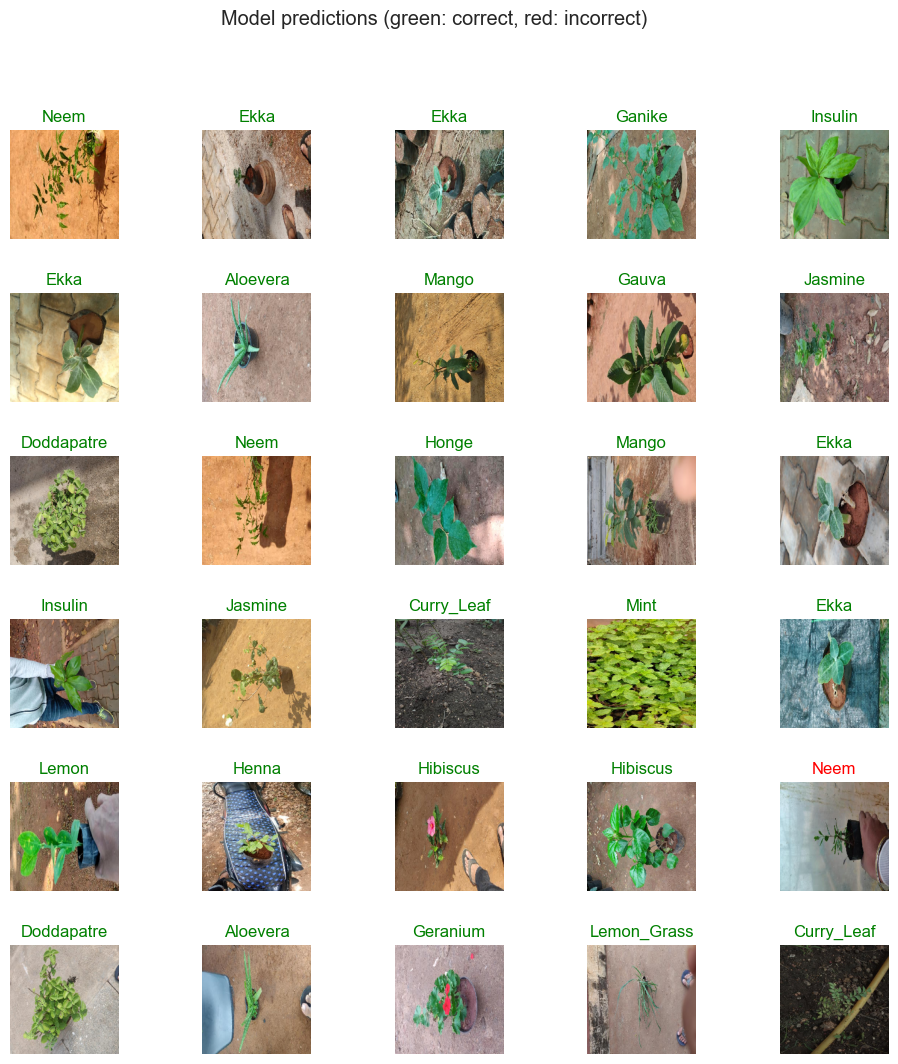

In [24]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off') 
    plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [25]:
from IPython.display import display, HTML

def display_plant_info(info):
    html_content = f"<h1 style='font-size:44px;'>Information About The Plant</h1><p style='font-size:18px;'>{info}</p>"
    display(HTML(html_content))

display_plant_info("")

In [26]:
import requests

def fetch_plant_info(search_term):
    # Step 1: Search for the plant on Wikipedia
    search_url = f"https://en.wikipedia.org/w/api.php"
    search_params = {
        "action": "query",
        "list": "search",
        "srsearch": search_term,
        "format": "json"
    }
    
    try:
        search_response = requests.get(search_url, params=search_params)
        search_data = search_response.json()
        
        if search_data["query"]["search"]:
            # Get the first search result's title
            page_title = search_data["query"]["search"][0]["title"]
            
            # Step 2: Fetch the page summary using the title
            summary_url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{page_title.replace(' ', '_')}"
            summary_response = requests.get(summary_url)
            summary_data = summary_response.json()
            
            description = summary_data.get("extract", "No description available.")
            page_url = summary_data.get("content_urls", {}).get("desktop", {}).get("page", "")
            
            return {"description": description, "url": page_url}
        else:
            return {"description": "No information found.", "url": ""}
    
    except Exception as e:
        print("Error fetching data:", e)
        return {"description": "Error fetching information.", "url": ""}

# Example usage
predicted_plant = "honge"
info = fetch_plant_info(predicted_plant)
print(f"Plant: {predicted_plant}")
print(f"Description: {info['description']}")
print(f"Read more: {info['url']}")

Plant: honge
Description: Pongamia pinnata is a species of tree in the pea family, Fabaceae, native to eastern and tropical Asia, Australia, and the Pacific islands. It is the sole species in genus Pongamia. It is often known by the synonym Millettia pinnata. Its common names include Indian beech, Karanja, and Pongame oiltree.
Read more: https://en.wikipedia.org/wiki/Pongamia


# Save Model and Weights and Evaluating the performance of the model

In [27]:
model.save("C:\\Users\\KIIT\\Desktop\\Medicinal Plant Identifier\\medplants2.keras")
model.save_weights("C:\\Users\\KIIT\Desktop\\Medicinal Plant Identifier\\medplants2.weights.h5")
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\KIIT\AppData\Local\Temp\ipykernel_7992\2273160172.py:2: SyntaxWarning: invalid escape sequence '\D'
  model.save_weights("C:\\Users\\KIIT\Desktop\\Medicinal Plant Identifier\\medplants2.weights.h5")


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - acc: 0.9522 - loss: 0.1254
Final loss: 0.13
Final accuracy: 95.44%


In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import h5py
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# File path to your model
model_filename = "C:\\Users\\KIIT\\Downloads\\medplants2.h5"

# Read the model configuration from the .h5 file
with h5py.File(model_filename, 'r') as f:
    model_config = f.attrs.get('model_config')
    # Remove .decode('utf-8') since model_config is already a string
    if isinstance(model_config, bytes):
        model_config = model_config.decode('utf-8')
    # If it's already a string, no need to decode

# Load the configuration as a dictionary
config = json.loads(model_config)

# Function to recursively replace 'hub_url' with 'handle' in the config
def replace_hub_url_with_handle(obj):
    if isinstance(obj, dict):
        if 'class_name' in obj and obj['class_name'] == 'HubLayer':
            if 'config' in obj and 'hub_url' in obj['config']:
                obj['config']['handle'] = obj['config'].pop('hub_url')
        for key in obj:
            replace_hub_url_with_handle(obj[key])
    elif isinstance(obj, list):
        for item in obj:
            replace_hub_url_with_handle(item)

# Apply the function to the configuration
replace_hub_url_with_handle(config)

# Convert the modified configuration back to JSON
new_model_config = json.dumps(config)

# Reconstruct the model using the modified configuration
custom_objects = {'KerasLayer': hub.KerasLayer}
model = tf.keras.models.model_from_json(new_model_config, custom_objects=custom_objects)

# Load the model weights from the .h5 file
model.load_weights(model_filename)

# Proceed with image prediction
image_path = "C:\\Users\\KIIT\\Desktop\\dataset\\Mango\\429.jpg"
image_size = (224, 224)

# Load and preprocess image
xtest_image = Image.open(image_path)
xtest_image = xtest_image.resize(image_size)
xtest_image = np.array(xtest_image) / 255.0  # Normalize pixel values to [0, 1]
xtest_image = np.expand_dims(xtest_image, axis=0)  # Add batch dimension

# Predict class probabilities
class_probabilities = model.predict(xtest_image)

# Find the class with the highest probability
predicted_class = np.argmax(class_probabilities)

# Display the image
imggg = cv2.imread(image_path)
imggg = cv2.resize(imggg, (300, 300))
plt.imshow(cv2.cvtColor(imggg, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()

# Define class labels
class_labels = [
    'Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avocado',
    'Bamboo', 'Basale', 'Betel', 'Betel_Nut', 'Brahmi', 'Castor', 'Curry_Leaf',
    'Doddapatre', 'Ekka', 'Ganike', 'Guava', 'Geranium', 'Henna', 'Hibiscus', 'Honge',
    'Insulin', 'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint', 'Nagadali', 'Neem',
    'Nithyapushpa', 'Nooni', 'Papaya', 'Pepper', 'Pomegranate', 'Raktachandini', 'Rose',
    'Sapota', 'Tulasi', 'Wood_sorel'
]

# Print the class label
predicted_class_label = class_labels[predicted_class]
print(f"This image belongs to: {predicted_class_label}")


TypeError: Could not locate class 'Sequential'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}}, {'class_name': 'HubLayer', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'handle': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'}}, {'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'rate': 0.4, 'seed': None, 'noise_shape': None}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 17, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}], 'build_input_shape': [None, 224, 224, 3]}}

# Predicted New Sample

In [44]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Define both KerasLayer and HubLayer in custom_objects
custom_objects = {'KerasLayer': hub.KerasLayer, 'HubLayer': hub.KerasLayer}

# Load saved model with custom objects

model = load_model("C:/Users/KIIT/Downloads/medplants2.keras", custom_objects=custom_objects)

image_path = r'C:\Users\KIIT\Desktop\dataset\Mango\429.jpg'
image_size = (224, 224)

# Load and preprocess image
xtest_image = Image.open(image_path)
xtest_image = xtest_image.resize(image_size)
xtest_image = np.array(xtest_image) / 255.0  # Normalize pixel values to [0, 1]

# Expand dimensions to match model's input shape
xtest_image = np.expand_dims(xtest_image, axis=0)

# Predict class probabilities
class_probabilities = model.predict(xtest_image)

# Find the class with the highest probability
predicted_class = np.argmax(class_probabilities)

# Display the image
imggg = cv2.imread(image_path)
imggg = cv2.resize(imggg, (300, 300))
plt.imshow(cv2.cvtColor(imggg, cv2.COLOR_BGR2RGB))
plt.show()

# Define class labels
class_labels = ['Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado', 
                'Bamboo', 'Basale', 'Betel', 'Betel_Nut', 'Brahmi', 'Castor', 'Curry_Leaf', 
                'Doddapatre', 'Ekka', 'Ganike', 'Gauva', 'Geranium', 'Henna', 'Hibiscus', 
                'Honge', 'Insulin', 'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint', 
                'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Pappaya', 'Pepper', 'Pomegranate', 
                'Raktachandini', 'Rose', 'Sapota', 'Tulasi', 'Wood_sorel']  # Replace with actual class labels

# Print the class label
predicted_class_label = class_labels[predicted_class]
print(f"This image belongs to: {predicted_class_label}")


TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2401387754416}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': None, 'class_name': 'HubLayer', 'config': {'hub_url': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'HubLayer', 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2401387754416}, 'rate': 0.4, 'seed': None, 'noise_shape': None}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 2401387754416}, 'units': 17, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1280]}}], 'build_input_shape': [None, 224, 224, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['acc'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'tensorflow_hub.keras_layer.KerasLayer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'HubLayer', 'config': {'hub_url': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'HubLayer', 'build_config': {'input_shape': [None, 224, 224, 3]}}.

Exception encountered: Error when deserializing class 'KerasLayer' using config={'hub_url': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}.

Exception encountered: KerasLayer.__init__() missing 1 required positional argument: 'handle'